In [2]:
import scanpy as sc
import pandas as pd
import math
import numpy as np
import scipy
from scipy import stats
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import warnings
from statsmodels.stats.multitest import multipletests
# from concurrent.futures import ThreadPoolExecutor
# from concurrent.futures import ProcessPoolExecutor
from joblib import Parallel, delayed
# import mplcursors
# import matplotlib.cm as cm
from multiprocessing import Process,Manager
import dill as pickle


warnings.filterwarnings("ignore")


In [ ]:
class SCPerturbationAnalysis:

    def __init__(self, file_path):
        self.__anndata = sc.read_h5ad(file_path)
        self.__expression = pd.DataFrame(self.__anndata.X, columns=self.__anndata.var.index, index=self.__anndata.obs.index).T
        # self.__perturb_fliter,self.__perturbation = self._fliter_by_cell_num()
        self.__perturbation=list(set(self.__anndata.obs['gene']))
        self.__gene_exp = self._calculate_gene_exp()
        self.__lfc = self._calculate_lfc()
        self.__pvalue = self._calculate_gene_pvalue()
        # self.__total_mRNA = self._calculate_total_mRNA()
        # self.__knock_gene_df = self._calculate_knocked_gene_info()
        # self.__downstream_counts, self.__downstream_genelist=self._find_downstream_gene()
        # self.__uptream_counts, self.__upstream_genelist=self._find_upstream_gene()

    def _fliter_by_cell_num(self):
        ### generate cell number distribution
        perturbation=list(set(self.__anndata.obs['gene']))
        cell_num=[]
        for gene in perturbation:
            expriment=self.__expression[self.__anndata.obs[self.__anndata.obs['gene']==gene].index]
            cell_num.append(expriment.shape[1])
        cell_num=pd.DataFrame(cell_num,index=perturbation,columns=['cell_num'])

        total_rna_std_log = [np.std(np.log2(self.__anndata.obs[self.__anndata.obs['gene'] == gene]['UMI_count'])) for gene in perturbation]
        total_rna_log = [np.log2(self.__anndata.obs[self.__anndata.obs['gene'] == gene]['UMI_count']).mean() for gene in perturbation]
        total_rna_std=np.exp(total_rna_std_log)
        total_rna = np.exp(total_rna_log)
        perturb_fliter=pd.DataFrame(zip(total_rna,total_rna_std,total_rna_std/total_rna),index=perturbation,columns=['total_rna','total_rna_std','total_rna_cv'])
        perturb_fliter['cell_number']=cell_num['cell_num']

        ### update perturbation list after fliter with cell_number
        pertubation_flited=perturb_fliter[perturb_fliter['cell_number']>15].index

        return perturb_fliter,pertubation_flited

    def _calculate_gene_exp(self):
        gene_exp = pd.DataFrame()
        for gene in self.__perturbation:
            cells = self.__anndata.obs[self.__anndata.obs['gene'] == gene]
            expression_filtered = pd.DataFrame(self.__expression[cells.index])
            gene_exp = gene_exp.append(expression_filtered.mean(axis=1), ignore_index=True)
        gene_exp.index = self.__perturbation
        return gene_exp

    def _calculate_lfc(self):
        lfc = self.__gene_exp / self.__gene_exp.loc['non-targeting']
        lfc = np.log2(lfc.replace([np.inf, -np.inf], [1000, -1000]))
        rename_dict = dict(zip(self.__anndata.var.index, self.__anndata.var['gene_name']))
        rename_dict['ENSG00000284024'] = 'MSANTD7'
        lfc.rename(columns=rename_dict, inplace=True)
        return lfc

    def _calculate_gene_pvalue(self):
        non_targeting = self.__expression[self.__anndata.obs[self.__anndata.obs['gene'] == 'non-targeting'].index]

        # Function to calculate p-value for a gene
        def ranksums_parallel(gene):
            multitest = False
            cells = self.__anndata.obs[self.__anndata.obs['gene'] == gene]
            expression_filtered = self.__expression[cells.index]
            p_values = expression_filtered.apply(lambda row: ranksums(row, non_targeting.loc[row.name])[1], axis=1)
            if multitest:
                p_values = multipletests(p_values, method='fdr_bh')[1]
            return p_values

        # Use Parallel to calculate p-values for all genes in parallel
        num_cores = -1  # Use all available cores, adjust as needed
        with Parallel(n_jobs=num_cores) as parallel:
            results = parallel(delayed(ranksums_parallel)(gene) for gene in self.__perturbation)

        gene_pvalue = pd.DataFrame({gene: p_values for gene, p_values in zip(self.__perturbation, results)})
        rename_dict = dict(zip(self.__anndata.var.index, self.__anndata.var['gene_name']))
        rename_dict['ENSG00000284024'] = 'MSANTD7'
        gene_pvalue.rename(index=rename_dict, inplace=True)
        gene_pvalue = gene_pvalue.T
        return gene_pvalue

    def _calculate_total_mRNA(self):
        control = self.__anndata.obs[self.__anndata.obs['gene'] == 'non-targeting']
        total_rna_log = [np.log2(self.__anndata.obs[self.__anndata.obs['gene'] == gene]['UMI_count']).mean() for gene in self.__perturbation]
        p_value = [scipy.stats.ttest_ind(np.log2(control['UMI_count']), np.log2(self.__anndata.obs[self.__anndata.obs['gene'] == gene]['UMI_count']))[1] for gene in self.__perturbation]
        adjusted_pvalue=multipletests(p_value,method='fdr_bh')[1]
        total_rna = np.exp(total_rna_log)
        total_mRNA = pd.DataFrame(total_rna, index=self.__perturbation, columns=['total_mRNA'])
        total_mRNA['ratio'] = total_mRNA / total_mRNA.loc['non-targeting', 'total_mRNA']
        total_mRNA['logFC'] = np.log2(total_mRNA['ratio'])
        total_mRNA['p_value'] = adjusted_pvalue
        return total_mRNA

    def _calculate_knocked_gene_info(self):
        gene_name_ary = []
        lfc_ary = []
        gene_ary_no_knock = []
        gene_ary_knocked = []
        rename_dict = dict(zip(self.__anndata.var.index, self.__anndata.var['gene_name']))
        rename_dict['ENSG00000284024'] = 'MSANTD7'
        self.__gene_exp.rename(columns=rename_dict, inplace=True)
        for knock_gene in self.__lfc.index:
            if knock_gene in self.__lfc.columns:
                gene_name_ary.append(knock_gene)
                lfc_ary.append(self.__lfc.loc[knock_gene, knock_gene])
                gene_ary_knocked.append(self.__gene_exp.loc[knock_gene, knock_gene])
                gene_ary_no_knock.append(self.__gene_exp.loc['non-targeting', knock_gene])
        knock_gene_df = pd.DataFrame(zip(gene_name_ary, lfc_ary, gene_ary_no_knock, gene_ary_knocked), columns=['gene_name', 'log FC', 'original', 'knocked'])
        knock_gene_df.set_index("gene_name", inplace=True)
        knock_gene_df['variation']=knock_gene_df['knocked']-knock_gene_df['original']
        ### 计算被敲除基因的相对值
        filtered = self.__total_mRNA[self.__total_mRNA.index.isin(knock_gene_df.index)]
        knock_gene_df['original_relative'] = knock_gene_df['original'] / self.__total_mRNA.loc['non-targeting', 'total_mRNA']
        knock_gene_df['knocked_relative'] = knock_gene_df['knocked'] / filtered['total_mRNA']
        knock_gene_df['variation_relative'] = knock_gene_df['knocked_relative'] - knock_gene_df['original_relative']
        return knock_gene_df

    def _find_downstream_gene(self):
        # Calculate the absolute difference between knocked and non-targeting for all pairs (i, j)
        # Pre-calculate the threshold for all rows
        non_targeting = self.__gene_exp.loc['non-targeting']
        thresholds = pd.DataFrame(np.percentile(np.abs(self.__gene_exp - non_targeting), 80, axis=1),index=self.__lfc.index)
        genelist = []

        for i in self.__lfc.index:
            abs_diff_non_targeting = np.abs(non_targeting - self.__gene_exp.loc[i])
            data=np.full((len(abs_diff_non_targeting),1),thresholds.loc[i])
            diff=pd.DataFrame(data,index=abs_diff_non_targeting.index)
            #
            mask = ((np.abs(self.__lfc.loc[i]) > 1.5).values)&(abs_diff_non_targeting > diff.iloc[:,0]) & ((p_value.loc[i].values < 0.05))
            gene_list = self.__lfc.columns[mask].tolist()
            genelist.append(gene_list)
       
        downstream_gene_list={key: values for key,values in zip(self.__lfc.index, genelist)}
        downstream_gene_list={key: [item for item in value if item!=key] for key,value in downstream_gene_list.items()}
        downstream_num=[]
        for key,value in downstream_gene_list.items():
            downstream_num.append(len(value))
        downstream_gene_counts=pd.DataFrame(downstream_num,index=lfc.index,columns=['counts'])
        return downstream_gene_counts, downstream_gene_list
    
    def _find_upstream_gene(self):
        upstream_dict = {element: [] for element in self.__lfc.columns}
        for key in self.__downstream_genelist:
            for element in self.__lfc.columns:
                if element in self.__downstream_genelist[key]:
                    upstream_dict[element].append(key)
        upstream_num=[]
        for key,value in upstream_dict.items():
            upstream_num.append(len(value))
        upstream_num=pd.DataFrame(upstream_num,index=self.__lfc.columns,columns=['counts'])
        return upstream_num, upstream_dict

    # def scatter_vocano_for_gene(self, gene, output_expression_is_0):
    #     expriment=self.__expression[self.__anndata.obs[self.__anndata.obs['gene']==gene].index]
    #     control=self.__expression[self.__anndata.obs[self.__anndata.obs['gene']=='non-targeting'].index].mean(axis=1)
    #     control.index=self.__lfc.columns

    #     # %matplotlib
    #     # control=self.__self.__expression[self.__self.__self.__anndata.obs[self.__self.__self.__anndata.obs['gene']=='non-targeting'].index].sample(n=expriment.shape[1],axis=1).mean(axis=1)
    #     expriment1=expriment.mean(axis=1)
    #     expriment1.index=self.__lfc.columns
    #     # print(f"knocked gene", gene)
    #     # print(f"cell number:",expriment.shape[1])

    #     ### scatter plot and valcano
    #     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    #     plt.rcParams.update({'font.size': 10})
    #     sct=ax1.scatter(np.log2(control),(np.log2(expriment1)),s=10)
    #     downstream_genes=self.__downstream_genelist[gene]
    #     ax1.scatter(np.log2(control[control.index.isin(downstream_genes)]),(np.log2(expriment1[control.index.isin(downstream_genes)])),edgecolors='orange',s=10, label='downstream genes')
    #     ax1.scatter(np.log2(control[gene]),(np.log2(expriment1[gene])),color='red',s=10, label='downstream genes')
    #     cursor = mplcursors.cursor(sct, hover=True)
    #     # by default the annotation displays the xy positions
    #     @cursor.connect("add")
    #     def on_add(sel):
    #         sel.annotation.set_text([control.index[sel.index],self.__gene_exp.loc[gene,control.index[sel.index]]
    #                                 ,self.__gene_exp.loc['non-targeting',control.index[sel.index]]])

    #     ax1.plot([np.log2(min(control)),np.log2(max(control))],[np.log2(min(control)),np.log2(max(control))],color='red',linestyle='--',label='y=x')
    #     ratio=self.__total_mRNA.loc[gene,'ratio']
    #     ax1.plot([np.log2(min(control)),np.log2(max(control))],[np.log2(min(control))*ratio,np.log2(max(control))*ratio],color='red',label=f"total_mRNS_ratio={ratio:.2f}")
    #     ax1.set_xlabel('log2(original UMI count)')
    #     ax1.set_ylabel('log2(perturbed UMI count)')
    #     ax1.set_title('original VS knocked-down gene expression')
    #     ax1.legend(loc='upper left',bbox_to_anchor=(0,1), frameon=False)

    #     p_values=self.___pvalue.loc[gene]
    #     log2_fold_change = self.___lfc.loc[gene]
    #     data = pd.DataFrame({'log2_fold_change': log2_fold_change, 'p_value': p_values},index=self.__gene_lfc.columns)
    #     p_value_threshold = 0.05
    #     fold_change_threshold = 1.5
    #     voc=ax2.scatter(data['log2_fold_change'], -np.log10(data['p_value']),color='gray', alpha=0.7)
    #     plt.scatter(data[data.index.isin(downstream_genes)]['log2_fold_change'], -np.log10(data[data.index.isin(downstream_genes)]['p_value']), color='red', alpha=0.7)
    #     cursor = mplcursors.cursor(voc, hover=True)
    #     @cursor.connect("add")
    #     def on_add(sel):
    #         sel.annotation.set_text(data.index[sel.index])
    #     ax2.axhline(-np.log10(p_value_threshold), color='blue', linestyle='--', label='p-value threshold')
    #     ax2.axvline(fold_change_threshold, color='green', linestyle='--', label='fold change threshold')
    #     ax2.axvline(-fold_change_threshold, color='green', linestyle='--')
    #     ax2.set_xlabel('log2 Fold Change')
    #     ax2.set_ylabel('-log10(p-value)')
    #     ax2.set_title('Gene Volcano Plot')
    #     if output_expression_is_0==True:
    #         expr=pd.DataFrame(expriment1,columns=['UMI'])
    #         zero_gene=expr[expr['UMI']==0].index
    #         print(f'genes with 0 expression after perturbation)')
    #         return zero_gene

    @property
    def gene_exp(self):
        gene_exp=self.__gene_exp
        gene_exp.columns=self.__lfc.columns
        return gene_exp
    
    @property
    def perturb_fliter(self):
        return self.__perturb_fliter

    @property
    def gene_lfc(self):
        return self.__lfc

    @property
    def gene_pvalue(self):
        return self.__pvalue

    @property
    def total_mRNA_info(self):
        return self.__total_mRNA

    @property
    def knocked_gene_info(self):
        return self.__knock_gene_df

    @property
    def downstream_gene_counts(self):
        return self.__downstream_counts
    
    @property
    def downstream_gene_list(self):
        return self.__downstream_genelist   
    
    @property
    def uptream_gene_counts(self):
        return self.__uptream_counts
    
    @property
    def upstream_gene_list(self):
        return self.__upstream_genelist  



    def get_all_info_for_perturbation(self,gene):
        output_df1=pd.DataFrame(zip(self.__gene_exp.loc[gene].T, self.__gene_exp.loc['non-targeting'].T, self.__lfc.loc[gene].T, self.__pvalue.loc[gene]),columns=['gene_exp','gene_exp_control','lfc','gene_pvalue'], index=self.__lfc.columns).T
        print(f"knocked gene is {gene}, and the basic information is shown as below: ")
        print(output_df1[gene].to_string())
        print()
        print(f"cell number of this perturbation:")
        print(self.__perturb_fliter.loc[gene,'cell_number'])
        print()
        print(f"total_mRNA info:")
        print(self.__total_mRNA.loc[gene])
        print()
        print(f"knocked gene info:")
        print(self.__knock_gene_df.loc[gene])
        print()
        print(f"downstream genes counts is: {self.__downstream_counts.loc[gene,'counts']}")
        print(f"downstream genes:")
        print(self.__downstream_genelist[gene])
        print()
        print(f"upstream genes counts is: {self.__uptream_counts.loc[gene,'counts']}")
        print(f"upstream genes:")
        print(self.__upstream_genelist[gene])

        self.scatter_vocano_for_gene(gene,True)

        
        ### 对于要观测的target gene，观测其下游基因的表达分布及该perturbation在分布中的位置
        print(f"Gene expression level for each downstream gene")
        gene_list = list(self.__downstream_genelist[gene])
        num_genes = len(gene_list)
        cols = 6
        rows = (num_genes + cols - 1) // cols  # Round up to the nearest integer
        plt.figure(dpi=300)
        gs = plt.GridSpec(rows, cols)  # Create a grid for subplots
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
        plt.rcParams.update({'font.size': 3})
        for i, gene_name in enumerate(gene_list):
            ax = plt.subplot(gs[i])  # Create a subplot in the grid
            data = self.__gene_exp[gene_name]
            sns.distplot(data, axlabel=gene_name, ax=ax)
            ax.axvline(self.__gene_exp.loc[gene, gene_name], color='red', lw=0.5)
        # Remove any empty subplots in the grid
        for i in range(num_genes, rows * cols):
            plt.delaxes(plt.subplot(gs[i]))
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        plt.tick_params(pad=0.1)
        plt.show()

        ### sequencing quality
        # df=self.__expression[self.__anndata.obs[self.__anndata.obs['gene']==gene].index]
        # zero_per=df.eq(0).sum()/df.shape[0]
        # print(f"mean zero_percent:",zero_per.mean())
        # print(f"Sequencing quality:")
        # plt.rcParams.update({'font.size':10})
        # sns.displot(zero_per)
        # plt.xlabel("zero percent of each cell")
        # plt.show()
        # print()


        # ### 画火山图
        # print(f"火山图：")
        # plt.rcParams.update({'font.size':10})
        # p_values=self.__pvalue.loc[gene]
        # log2_fold_change = self.__lfc.loc[gene]
        # data = pd.DataFrame({'log2_fold_change': log2_fold_change, 'p_value': p_values},index=self.__lfc.index)
        # p_value_threshold = 0.05
        # fold_change_threshold = 1.5
        # plt.scatter(data['log2_fold_change'], -np.log10(data['p_value']), color='gray', alpha=0.7)
        # down_list=self.__downstream_genelist[gene]
        # plt.scatter(data[data.index.isin(down_list)]['log2_fold_change'], -np.log10(data[data.index.isin(down_list)]['p_value']), color='red', alpha=0.7)
        # plt.axhline(-np.log10(p_value_threshold), color='blue', linestyle='--', label='p-value threshold')
        # plt.axvline(fold_change_threshold, color='green', linestyle='--', label='fold change threshold')
        # plt.axvline(-fold_change_threshold, color='green', linestyle='--')
        # plt.xlabel('log2 Fold Change')
        # plt.ylabel('-log10(p-value)')
        # plt.legend()
        # plt.title('Volcano Plot')
        # plt.show()
        # print()

        ### 画total mRNA的分布图
        # print(f"total mRNA distribution:")
        # sns.distplot(self.__total_mRNA['total_mRNA'])
        # plt.axvline(self.__total_mRNA.loc[gene,'total_mRNA'], color='red', label=gene)
        # plt.show()
        # print()

        ### 画下游基因counts分布图
        # print(f"log2(downstream genes count) distribution:")
        # sns.distplot(np.log2(self.__downstream_counts['counts']+1))
        # plt.axvline(np.log2(self.__downstream_counts.loc[gene,'counts']+1), color='red', label=gene)
        # plt.xlabel('log2(downstream genes count)')
        # plt.show()
        # print()


        # ### output cell number and scatter(expression of original and perturbed together with total mRNA ratio line)
        # expriment=self.__expression[self.__anndata.obs[self.__anndata.obs['gene']==gene].index]
        # control=self.__expression[self.__anndata.obs[self.__anndata.obs['gene']=='non-targeting'].index].mean(axis=1)
        # expriment1=expriment.mean(axis=1)
        # print(f"knocked gene", gene)
        # print(f"cell number:",expriment.shape[1])

        # sns.scatterplot(np.log2(control),(np.log2(expriment1)))
        # plt.plot([np.log2(min(control)),np.log2(max(control))],[np.log2(min(control)),np.log2(max(control))],color='red',linestyle='--',label='y=x')
        # ratio=self.__total_mRNA.loc[gene,'ratio']
        # plt.plot([np.log2(min(control)),np.log2(max(control))],[np.log2(min(control))*ratio,np.log2(max(control))*ratio],color='red',label=f"total_mRNS_ratio={ratio:.2f}")
        # plt.xlabel('log2(original gene count)')
        # plt.ylabel('log2(perturbed gene count)')
        # plt.legend()
        # print()

    def generate_global_stats(self):
        
        # ### sequencing quality
        # print(f"Overview of sequencing quality:")
        # zero_per=self.__expression.eq(0).sum()/self.__expression.shape[0]
        # plt.rcParams.update({'font.size':10})
        # sns.displot(zero_per)
        # plt.xlabel("zero percent of each cell")
        # print(f"mean zero_percent for all cell:",zero_per.mean())
        # plt.show()
        
        ### cell number distribution
        print(f"cell number distribution for each perturbation:")
        %matplotlib inline
        sns.distplot(np.log2(self.__perturb_fliter['cell_number']))
        plt.axvline(x=np.log2(self.__perturb_fliter.loc['non-targeting','cell_number']), color='red', label='non-targeting')
        plt.xlabel('log2(cell_number)')
        plt.title('Perturtion cell number distribution')
        plt.legend()
        plt.show()
        print()

        ### plotg scatter: cell_number--total_mrna_cv  (the basis of filter accroding to cell_number)
        print(f"relationship between cell number and total mRNA CV:")
        sns.scatterplot(np.log2(self.__perturb_fliter['cell_number']),self.__perturb_fliter['total_rna_cv'])
        plt.axvline(x=4, color='red', label='threshold')
        plt.xlabel('log2(cell_number)')
        plt.legend()
        plt.show()
        print()

        ### total mRNA distribution visualization
        print(f"total mRNA distribution:")
        sns.distplot(self.__total_mRNA['total_mRNA'])
        plt.axvline(self.__total_mRNA.loc['non-targeting','total_mRNA'], color='red', label='non-targeting')
        plt.legend()
        plt.show()

        ### 画total mRNA火山图
        # print(f"total mRNA volcano plot:")
        # p_values=self.__total_mRNA['p_value']
        # log2_fold_change = self.__total_mRNA['logFC']
        # data = pd.DataFrame({'log2_fold_change': log2_fold_change, 'p_value': p_values})
        # p_value_threshold = 0.05
        # fold_change_threshold = 1
        # plt.scatter(data['log2_fold_change'], -np.log10(data['p_value']), alpha=0.7)
        # plt.xlabel('log2 Fold Change')
        # plt.ylabel('-log10(p-value)')
        # plt.title('total mRNA Volcano Plot')
        # plt.show()

        ### scatter: knocked gene change and total mRNA
        %matplotlib
        total_mRNA_hue=self.__total_mRNA[self.__total_mRNA.index.isin(self.__knock_gene_df.index)]
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios': [3, 2]})
        ax1.tick_params(axis='both',)
        ax1.set_title('original VS knocked-down gene expression level comparison')
        plt.rcParams.update({'font.size': 10})
        # scatter plot
        sc = ax1.scatter(np.log2(self.__knock_gene_df['original']),np.log2(self.__knock_gene_df['knocked']),c=total_mRNA_hue['ratio'].rename('total mRNA ratio'),cmap='bwr')
        ax1.plot([-9,max(np.log2(self.__knock_gene_df['original']))],[-9,max(np.log2(self.__knock_gene_df['original']))],color='gray',linestyle='--')
        cbar=plt.colorbar(sc)
        ax1.set_xlabel('log2(original gene expression)')
        ax1.set_ylabel('log2(knocked-down gene experssion)')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title('Detail info')
        ax2.set_xlim(0,2)
        cursor = mplcursors.cursor(sc, hover=True)# by default the annotation displays the xy positions
        @cursor.connect("add")
        def on_add(sel):
            sel.annotation.set_text(self.__knock_gene_df.index[sel.index])
            for text in ax2.texts:
                text.set_visible(False)
            source =self.__knock_gene_df.index[sel.index]
            # ax2.text(0.03, 0.2, source, ha='left', va='top', fontsize=7)
            ax2.axhline(0.3,lw=0.2,color='black',linestyle='--')
            ax2.text(0.03,0.9,"original expresison:")
            ax2.text(2,0.9,self.__gene_exp.loc['non-targeting',self.__knock_gene_df.index[sel.index]],ha='right')
            ax2.text(0.03,0.8,"knocked expresison:")
            ax2.text(2,0.8,self.__gene_exp.loc[self.__knock_gene_df.index[sel.index],self.__knock_gene_df.index[sel.index]],ha='right')
            ax2.text(0.03,0.7,"original total mRNA:")
            ax2.text(2,0.67,self.__total_mRNA.loc['non-targeting','total_mRNA'],ha='right')
            ax2.text(0.03,0.6,"knocked total mRNA:")
            ax2.text(2,0.57,self.__total_mRNA.loc[self.__knock_gene_df.index[sel.index],'total_mRNA'],ha='right')  
            ax2.text(0.03,0.5,"amount of downstream genes:")
            ax2.text(2,0.5,self.__downstream_counts.loc[self.__knock_gene_df.index[sel.index],'counts'],ha='right')
            ax2.text(0.03,0.4,"amount of upstream genes:")
            ax2.text(2,0.4,self.__uptream_counts.iloc[sel.index,0],ha='right')
            ax2.text(1,0.25,"Colors in scatterplot: total mRNA ratio",ha='center')
            ax2.text(1,0.15,"For more detailed infomation,",ha='center')
            ax2.text(1,0.12,"please run:",ha='center')
            ax2.text(1,0.09,"_.get_all_info_for_perturbation(gene)",ha='center')
        plt.legend()
        plt.show()
        print()

    
        ### info of knocked gene
        print(f"Details of the knocked-down genes:")
        print(f"All genes info higher expressed after knocked-down:")
        abnormal=self.__knock_gene_df[self.__knock_gene_df['variation']>0]
        for gene in abnormal.index:
            self.observe_gene_exp_scatter(gene)
        print()
    
        print(f"All genes info expression=0 after knocked-down:")
        to_zero=self.__knock_gene_d[self.__knock_gene_d['knocked']==0]
        sns.displot(to_zero['original'])
        plt.title('Original expression level of genes after perturbation is 0')
        plt.xlabel('original gene counts')
        plt.show()
        print(f'gene number(after perturbation expression=0):{len(to_zero.index)}')
        print('gene list(after perturbation expression=0):')
        print(to_zero.index)

analyse=SCPerturbationAnalysis('/home/rui/NFS/mount/Genome-scale_Perturb-seq/rpe1_raw_singlecell_01.h5ad')


In [9]:
anndata = sc.read_h5ad('/home/rui/NFS/mount/Genome-scale_Perturb-seq/rpe1_raw_singlecell_01.h5ad')
expression = pd.DataFrame(anndata.X, columns=anndata.var.index, index=anndata.obs.index).T

In [11]:
expression

cell_barcode,AAACCCAAGAAACTAC-53,AAACCCAAGAAGCCAC-51,AAACCCAAGAAGCGAA-32,AAACCCAAGAATACAC-44,AAACCCAAGAATCGAT-43,AAACCCAAGACAGCGT-12,AAACCCAAGACAGCGT-52,AAACCCAAGACATCAA-1,AAACCCAAGACCAGAC-18,AAACCCAAGACCTTTG-8,...,TTTGTTGTCTCCAAGA-47,TTTGTTGTCTCGAGTA-55,TTTGTTGTCTCTCCGA-20,TTTGTTGTCTGACAGT-14,TTTGTTGTCTGATGGT-14,TTTGTTGTCTGCACCT-44,TTTGTTGTCTGGGCAC-32,TTTGTTGTCTGTCCCA-37,TTTGTTGTCTTGGTCC-17,TTTGTTGTCTTTCCGG-22
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000188976,4.0,0.0,0.0,1.0,0.0,1.0,6.0,1.0,1.0,0.0,...,1.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,4.0
ENSG00000187583,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188290,5.0,3.0,2.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ENSG00000187608,1.0,1.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
ENSG00000188157,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000212907,16.0,1.0,2.0,2.0,2.0,5.0,8.0,4.0,3.0,2.0,...,1.0,3.0,3.0,3.0,3.0,10.0,7.0,1.0,0.0,4.0
ENSG00000198886,234.0,58.0,81.0,95.0,85.0,137.0,112.0,69.0,59.0,54.0,...,44.0,79.0,60.0,81.0,77.0,188.0,53.0,37.0,57.0,87.0
ENSG00000198786,45.0,13.0,27.0,33.0,19.0,39.0,33.0,31.0,13.0,20.0,...,5.0,20.0,17.0,31.0,22.0,60.0,23.0,14.0,10.0,38.0


In [17]:
expression[anndata.obs[anndata.obs['gene'] == 'non-targeting'].index]

cell_barcode,AAACCCAAGAGAGAAC-35,AAACCCAAGCGGACAT-34,AAACCCAAGTGCACCC-42,AAACCCAAGTGCCGAA-55,AAACCCACAATGCAGG-12,AAACCCAGTAGGTTTC-5,AAACCCAGTTCAAGGG-31,AAACCCATCCCAGTGG-4,AAACCCATCGACATCA-18,AAACCCATCGGTGTAT-26,...,TTTGTTGAGTCACGAG-38,TTTGTTGCAAAGCGTG-16,TTTGTTGCAACTCCCT-11,TTTGTTGCACCAACAT-38,TTTGTTGCACGACAAG-1,TTTGTTGCATTCACCC-42,TTTGTTGGTGAGTGAC-55,TTTGTTGTCCATCTCG-35,TTTGTTGTCGGCTCTT-36,TTTGTTGTCTTTCCGG-22
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000188976,2.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,4.0
ENSG00000187583,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSG00000188290,0.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0
ENSG00000187608,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ENSG00000188157,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000212907,2.0,2.0,1.0,6.0,3.0,8.0,3.0,5.0,0.0,3.0,...,5.0,2.0,4.0,3.0,2.0,4.0,6.0,0.0,3.0,4.0
ENSG00000198886,43.0,61.0,65.0,81.0,46.0,83.0,85.0,75.0,35.0,44.0,...,55.0,95.0,73.0,63.0,46.0,57.0,113.0,0.0,75.0,87.0
ENSG00000198786,14.0,19.0,21.0,40.0,18.0,29.0,31.0,28.0,6.0,24.0,...,23.0,26.0,26.0,29.0,21.0,22.0,26.0,5.0,15.0,38.0


In [4]:
! pip install dill


     |████████████████████████████████| 115 kB 201 kB/s eta 0:00:01


In [ ]:
### scatter and vocano plot for each perturbation
total_mRNA=analyse.total_mRNA_info
expression=analyse._SCPerturbationAnalysis__expression
anndata=analyse._SCPerturbationAnalysis__anndata
downstream_gene_list=downstream_gene_list

def scatter_vocano_for_gene(gene,output_expression_is_0):
    expriment=expression[anndata.obs[anndata.obs['gene']==gene].index]
    control=expression[anndata.obs[anndata.obs['gene']=='non-targeting'].index].mean(axis=1)
    control.index=analyse.gene_lfc.columns
    %matplotlib inline
    plt.hist(control)
    plt.show()


    %matplotlib
    # control=self.__self.__expression[self.__self.__anndata.obs[self.__self.__anndata.obs['gene']=='non-targeting'].index].sample(n=expriment.shape[1],axis=1).mean(axis=1)
    expriment1=expriment.mean(axis=1)
    expriment1.index=analyse.gene_lfc.columns
    print(f"knocked gene", gene)
    print(f"cell number:",expriment.shape[1])

    ### scatter plot and valcano
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    plt.rcParams.update({'font.size': 10})
    sct=ax1.scatter(np.log2(control),(np.log2(expriment1)),s=10)
    downstream_genes=downstream_gene_list[gene]
    ax1.scatter(np.log2(control[control.index.isin(downstream_genes)]),(np.log2(expriment1[control.index.isin(downstream_genes)])),edgecolors='orange',s=10, label='downstream genes')
    ax1.scatter(np.log2(control[gene]),(np.log2(expriment1[gene])),color='red',s=10, label='downstream genes')
    cursor = mplcursors.cursor(sct, hover=True)
    # by default the annotation displays the xy positions
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text([control.index[sel.index],gene_exp.loc[gene,control.index[sel.index]]
                                ,gene_exp.loc['non-targeting',control.index[sel.index]]])

    ax1.plot([np.log2(min(control)),np.log2(max(control))],[np.log2(min(control)),np.log2(max(control))],color='red',linestyle='--',label='y=x')
    ratio=total_mRNA.loc[gene,'ratio']
    ax1.plot([np.log2(min(control)),np.log2(max(control))],[np.log2(min(control))*ratio,np.log2(max(control))*ratio],color='red',label=f"total_mRNS_ratio={ratio:.2f}")
    ax1.set_xlabel('log2(original UMI count)')
    ax1.set_ylabel('log2(perturbed UMI count)')
    ax1.set_title('original VS knocked-down gene expression')
    ax1.legend(loc='upper left',bbox_to_anchor=(0,1), frameon=False)
    # return 敲完表达为0的基因，敲完表达变化大的基因


    p_values=analyse.gene_pvalue.loc[gene]
    log2_fold_change = analyse.gene_lfc.loc[gene]
    data = pd.DataFrame({'log2_fold_change': log2_fold_change, 'p_value': p_values},index=analyse.gene_lfc.columns)
    p_value_threshold = 0.05
    fold_change_threshold = 1.5
    voc=ax2.scatter(data['log2_fold_change'], -np.log10(data['p_value']),color='gray', alpha=0.7)
    plt.scatter(data[data.index.isin(downstream_genes)]['log2_fold_change'], -np.log10(data[data.index.isin(downstream_genes)]['p_value']), color='red', alpha=0.7)
    cursor = mplcursors.cursor(voc, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(data.index[sel.index])
    ax2.axhline(-np.log10(p_value_threshold), color='blue', linestyle='--', label='p-value threshold')
    ax2.axvline(fold_change_threshold, color='green', linestyle='--', label='fold change threshold')
    ax2.axvline(-fold_change_threshold, color='green', linestyle='--')
    ax2.set_xlabel('log2 Fold Change')
    ax2.set_ylabel('-log10(p-value)')
    ax2.set_title('Gene Volcano Plot')
    if output_expression_is_0==True:
        expr=pd.DataFrame(expriment1,columns=['UMI'])
        zero_gene=expr[expr['UMI']==0].index
        print(f'genes with 0 expression after perturbation)')
        return zero_gene

scatter_vocano_for_gene('IMP4',True)
# CBX1

In [441]:
### global scatter plot
total_mRNA=analyse.total_mRNA_info
knock_gene_df=analyse.knocked_gene_info
total_mRNA_hue=total_mRNA[total_mRNA.index.isin(knock_gene_df.index)]




%matplotlib


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios': [3, 2]})
ax1.tick_params(axis='both',)
ax1.set_title('original VS knocked-down gene expression level comparison')
plt.rcParams.update({'font.size': 10})
# scatter plot
sc = ax1.scatter(np.log2(knock_gene_df['original']),np.log2(knock_gene_df['knocked']),c=total_mRNA_hue['ratio'].rename('total mRNA ratio'),cmap='bwr')
ax1.plot([-9,max(np.log2(knock_gene_df['original']))],[-9,max(np.log2(knock_gene_df['original']))],color='gray',linestyle='--')
# cax=plt.axes([0.95,0.1,0.03,0,8])
cbar=plt.colorbar(sc)
# cbar.set_lable('Color value')
# axis 1 labels
ax1.set_xlabel('log2(original gene expression)')
ax1.set_ylabel('log2(knocked-down gene experssion)')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Detail info')
ax2.set_xlim(0,2)

cursor = mplcursors.cursor(sc, hover=True)# by default the annotation displays the xy positions
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set_text(knock_gene_df.index[sel.index])
    for text in ax2.texts:
        text.set_visible(False)
    source =knock_gene_df.index[sel.index]
    # ax2.text(0.03, 0.2, source, ha='left', va='top', fontsize=7)
    ax2.axhline(0.3,lw=0.2,color='black',linestyle='--')
    ax2.text(0.03,0.9,"original expresison:")
    ax2.text(2,0.9,analyse._SCPerturbationAnalysis__gene_exp.loc['non-targeting',knock_gene_df.index[sel.index]],ha='right')
    ax2.text(0.03,0.8,"knocked expresison:")
    ax2.text(2,0.8,analyse._SCPerturbationAnalysis__gene_exp.loc[knock_gene_df.index[sel.index],knock_gene_df.index[sel.index]],ha='right')
    ax2.text(0.03,0.7,"original total mRNA:")
    ax2.text(2,0.67,total_mRNA.loc['non-targeting','total_mRNA'],ha='right')
    ax2.text(0.03,0.6,"knocked total mRNA:")
    ax2.text(2,0.57,total_mRNA.loc[knock_gene_df.index[sel.index],'total_mRNA'],ha='right')  
    ax2.text(0.03,0.5,"amount of downstream genes:")
    ax2.text(2,0.5,analyse._SCPerturbationAnalysis__downstream_counts.loc[knock_gene_df.index[sel.index],'counts'],ha='right')
    ax2.text(0.03,0.4,"amount of upstream genes:")
    ax2.text(2,0.4,upstream_num.iloc[sel.index,0],ha='right')
    ax2.text(1,0.25,"Colors in scatterplot: total mRNA ratio",ha='center')
    ax2.text(1,0.15,"For more detailed infomation,",ha='center')
    ax2.text(1,0.12,"please run:",ha='center')
    ax2.text(1,0.09,"_.get_all_info_for_perturbation(gene)",ha='center')
plt.legend()
plt.show()

No handles with labels found to put in legend.


Using matplotlib backend: Qt5Agg


In [371]:
# 寻找第一类TF，返回其下游基因数量和list

# Pre-calculate the threshold for all rows
non_targeting = gene_exp.loc['non-targeting']
thresholds = pd.DataFrame(np.percentile(np.abs(gene_exp - non_targeting), 80, axis=1),index=lfc.index)

downstream_counts = []
genelist = []
num = 0

for i in lfc.index:
    abs_diff_non_targeting = np.abs(non_targeting - gene_exp.loc[i])
    data=np.full((len(abs_diff_non_targeting),1),thresholds.loc[i])
    diff=pd.DataFrame(data,index=abs_diff_non_targeting.index)
    #
    mask = ((np.abs(lfc.loc[i]) > 1.5).values)&(abs_diff_non_targeting > diff.iloc[:,0]) & ((p_value.loc[i].values < 0.05))
    gene_list = lfc.columns[mask].tolist()
    genelist.append(gene_list)
downstream_gene_list={key: values for key,values in zip(lfc.index, genelist)}
downstream_gene_list={key: [item for item in value if item!=key] for key,value in downstream_gene_list.items()}
downstream_num=[]
for key,value in downstream_gene_list.items():
    downstream_num.append(len(value))
downstream_gene_counts=pd.DataFrame(downstream_num,index=lfc.index,columns=['counts'])

In [370]:
len(downstream_num)

8749

In [367]:


downstream_gene_list['CBX1']
# ['CBX1']

['GNPNAT1']

In [348]:
### 查找上游基因
def find_keys_containing_elements(data_dict, specific_elements):
    result_dict = {element: [] for element in specific_elements}
    for key in data_dict:
        for element in specific_elements:
            if element in data_dict[key]:
                result_dict[element].append(key)
    return result_dict
observe_gene=lfc.columns
dict=find_keys_containing_elements(downstream_gene_list,observe_gene)

In [395]:
upstream_num=[]
for key,value in dict.items():
    upstream_num.append(len(value))
len(upstream_num)

8749

In [292]:
### knocked gene expression difference distribution and volcano plot
# diff_exp=analyse.knocked_gene_info['variation']
# sns.scatterplot(analyse.knocked_gene_info['original'],analyse.knocked_gene_info['knocked'])
total_mRNA_hue=total_mRNA[total_mRNA.index.isin(analyse.knocked_gene_info.index)]
sns.scatterplot(np.log2(analyse.knocked_gene_info['original']),np.log2(analyse.knocked_gene_info['knocked']),hue=total_mRNA_hue['ratio'].rename('total mRNA ratio'),palette='Oranges')
abnormal=analyse.knocked_gene_info[analyse.knocked_gene_info['variation']>0]
# sns.scatterplot(np.log2(abnormal['original']),np.log2(abnormal['knocked']),color='red',label='abnormal')
plt.plot([-9,max(np.log2(analyse.knocked_gene_info['original']))],[-9,max(np.log2(analyse.knocked_gene_info['original']))],color='gray',linestyle='--')
plt.xlim(-9,8)
plt.xlabel('log2(original expression)')
plt.ylabel('log2(knocked experssion)')
plt.title('knocked gene experssion level')
plt.show()

In [ ]:
anndata=analyse._SCPerturbationAnalysis__anndata
expression=analyse._SCPerturbationAnalysis__expression
total_mRNA=analyse.total_mRNA_info
gene_lfc=analyse.gene_lfc
gene_p_value=analyse.gene_pvalue
gene_p_value.columns=gene_lfc.columns

def observe_gene_exp_scatter(gene):
    expriment=expression[anndata.obs[anndata.obs['gene']==gene].index]
    control=expression[anndata.obs[anndata.obs['gene']=='non-targeting'].index].mean(axis=1)
    # control=self.__expression[self.__anndata.obs[self.__anndata.obs['gene']=='non-targeting'].index].sample(n=expriment.shape[1],axis=1).mean(axis=1)
    expriment1=expriment.mean(axis=1)
    print(f"knocked gene", gene)
    print(f"cell number:",expriment.shape[1])
    
    ### scatter plot and valcano
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    sns.scatterplot(np.log2(control),(np.log2(expriment1)),ax=axes[0])
    axes[0].plot([np.log2(min(control)),np.log2(max(control))],[np.log2(min(control)),np.log2(max(control))],color='red',linestyle='--',label='y=x')
    ratio=total_mRNA.loc[gene,'ratio']
    axes[0].plot([np.log2(min(control)),np.log2(max(control))],[np.log2(min(control))*ratio,np.log2(max(control))*ratio],color='red',label=f"total_mRNS_ratio={ratio:.2f}")
    axes[0].set_xlabel('log2(original gene count)')
    axes[0].set_ylabel('log2(perturbed gene count)')
    axes[0].legend()


    p_values=gene_p_value.loc[gene]
    log2_fold_change = gene_lfc.loc[gene]
    data = pd.DataFrame({'log2_fold_change': log2_fold_change, 'p_value': p_values})
    p_value_threshold = 0.05
    fold_change_threshold = 1.5
    sns.scatterplot(data['log2_fold_change'], -np.log10(data['p_value']), c=np.where((data['p_value'] < p_value_threshold) & (np.abs(data['log2_fold_change']) > fold_change_threshold), 'red', 'gray'), alpha=0.7,ax=axes[1])
    axes[1].axhline(-np.log10(p_value_threshold), color='blue', linestyle='--', label='p-value threshold')
    axes[1].axvline(fold_change_threshold, color='green', linestyle='--', label='fold change threshold')
    axes[1].axvline(-fold_change_threshold, color='green', linestyle='--')
    axes[1].set_xlabel('log2 Fold Change')
    axes[1].set_ylabel('-log10(p-value)')
    axes[1].set_title('Gene Volcano Plot')
    plt.show()
    return data


### look into abnormal perturbations  'NUMA1'
# observe_gene_exp_scatter('NUMA1')
abnormal=analyse.knocked_gene_info[analyse.knocked_gene_info['variation']>0]
for gene in abnormal.index:
    observe_gene_exp_scatter(gene)

In [ ]:
analyse.knocked_gene_info

Text(0.5, 6.79999999999999, 'original gene counts')

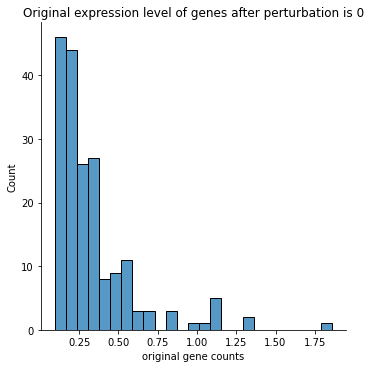

In [184]:
### output info of genes that after perturbation are 0
to_zero=analyse.knocked_gene_info[analyse.knocked_gene_info['knocked']==0]
sns.displot(to_zero['original'])
plt.title('Original expression level of genes after perturbation is 0')
plt.xlabel('original gene counts')

In [13]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import scanpy as sc
import pandas as pd
pandas2ri.activate()
%load_ext rpy2.ipython

anndata=sc.read_h5ad('/home/rui/NFS/mount/Genome-scale_Perturb-seq/rpe1_raw_singlecell_01.h5ad')
exp=pd.DataFrame(anndata.X, columns=anndata.var.index, index=anndata.obs.index).T
rename_dict = dict(zip(anndata.var.index, anndata.var['gene_name']))
rename_dict['ENSG00000284024'] = 'MSANTD7'
exp.rename(index=rename_dict, inplace=True)
gene_list=list(set(anndata.obs['gene']))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:


for gene in gene_list:
    exp_filtered = pd.DataFrame(exp[(anndata.obs[anndata.obs['gene'] == gene]).index])


r_df_cdata = pandas2ri.py2rpy(anndata.obs.loc[exp_filtered.T.index]['gene'])
r_df_fdata = pandas2ri.py2rpy(pd.DataFrame(exp_filtered.index))

# exp_filtered=exp_filtered.reset_index(drop=True)
# exp_filtered.columns=range(len(exp_filtered.columns))
r_df_exp = pandas2ri.py2rpy(exp_filtered)




r_code = """"
library(MAST)
mast_object <- FromMatrix(r_df_exp, r_df_cdata, r_df_fdata)

"""

# r(r_code)

In [10]:
! pip uninstall tf-nightly -y

Found existing installation: tf-nightly 2.14.0.dev20230723
Uninstalling tf-nightly-2.14.0.dev20230723:
  Would remove:
    /home/rui/software/anaconda3/bin/estimator_ckpt_converter
    /home/rui/software/anaconda3/bin/import_pb_to_tensorboard
    /home/rui/software/anaconda3/bin/saved_model_cli
    /home/rui/software/anaconda3/bin/tf_upgrade_v2
    /home/rui/software/anaconda3/bin/tflite_convert
    /home/rui/software/anaconda3/bin/toco
    /home/rui/software/anaconda3/bin/toco_from_protos
    /home/rui/software/anaconda3/lib/python3.9/site-packages/tensorflow/*
    /home/rui/software/anaconda3/lib/python3.9/site-packages/tf_nightly-2.14.0.dev20230723.dist-info/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [12]:
import scanpy